In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# DataSet Description

* transactions occured in 2 days
* 492 frauds of total 284'807 transactions
* unbalanced data -> 0.172% frauds (total 2 classes: value 1 -> fraud)
    * do not use confusion matrix accuracy (due to unbalanced data)
    * Use Area Under the Precision-Recall Curve (AUPRC)
* columns: V1, ...V28
* result of PCA trafo
* without PCA: Fetures Time [s] (delta bzw. each transaction & Amount (transaction amount)
* Target data: class

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

Text(0.5, 1.0, 'Visualize target data')

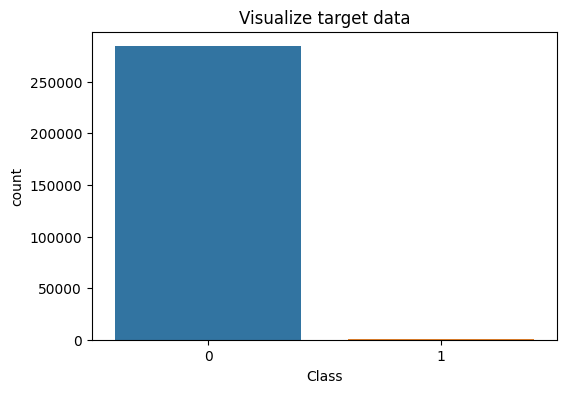

In [4]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.countplot(x='Class', data = df)
ax.set_title('Visualize target data')

# unbalanced data

<Axes: xlabel='Time', ylabel='Density'>

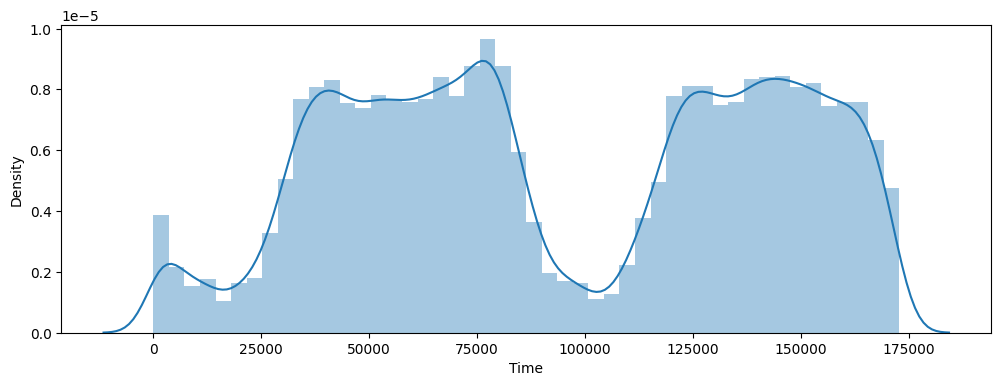

In [5]:
##
# 2 days of data -> 48 hours data

plt.figure(figsize=(12,4))
sns.distplot(df['Time'], bins = 48)

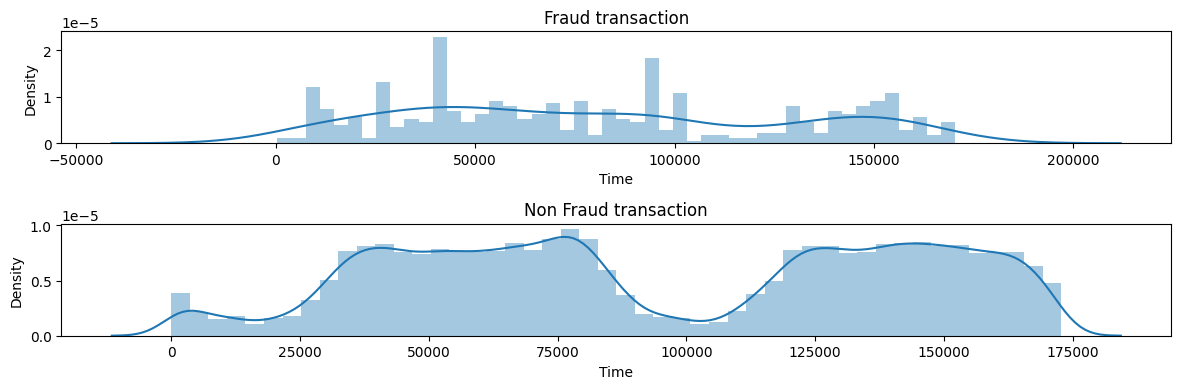

In [6]:
fig, axs = plt.subplots(2,1, figsize=(12,4))
sns.distplot(df[df['Class']==1]['Time'], bins=48, ax=axs[0])
sns.distplot(df[df['Class']==0]['Time'], bins=48, ax=axs[1])
axs[0].set_title('Fraud transaction')
axs[1].set_title('Non Fraud transaction')
plt.tight_layout()

In [7]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
len(df.dropna())- len(df)

0

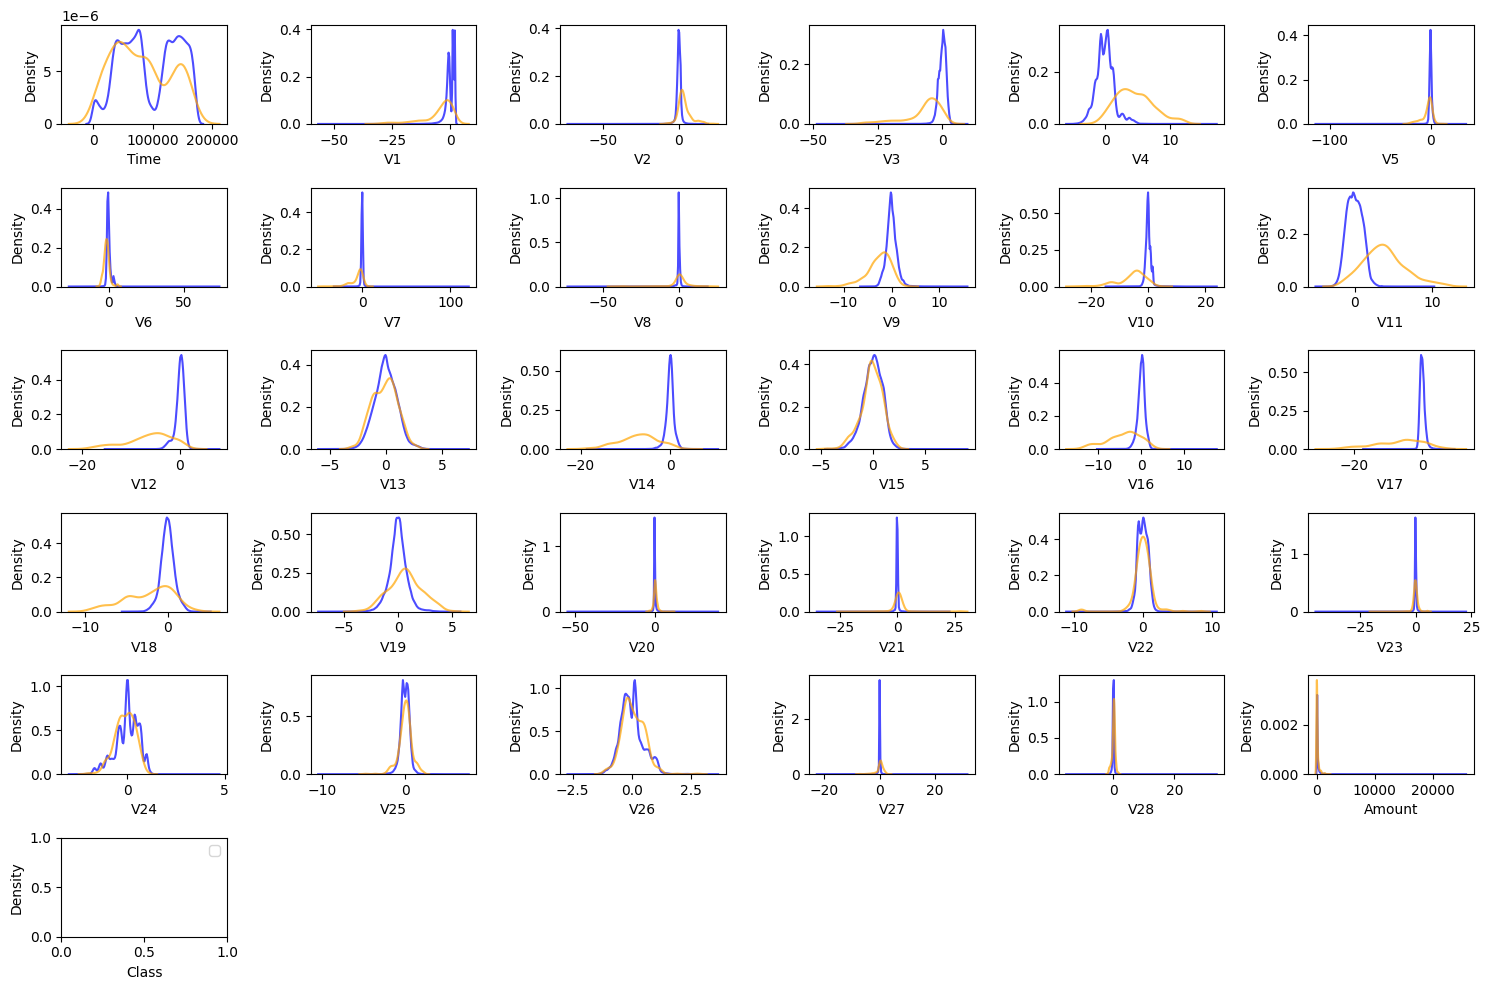

In [9]:
fig, axs = plt.subplots(6,6, figsize=(15,10))
axs = axs.ravel() # converting 2D array into 1D array

for i, column in enumerate(df.columns,0):
    sns.kdeplot(df[df['Class']==0][column], label='Class==0', color = 'blue', alpha=0.7,ax=axs[i])
    sns.kdeplot(df[df['Class']==1][column], label='Class==1', color = 'orange', alpha=0.7,ax=axs[i])
    #axs[i].hist(df[df['Class']==1][column], label='Class==1', color = 'orange', density=True, alpha=0.7)
    #axs[i].set_title(column)
    
for j in range(len(df.columns), len(axs)):
    fig.delaxes(axs[j])
plt.legend()
plt.tight_layout()

* for some feature, we can observe a clear seperation between both classes w.r.t. distribution (e.g. V4)
* for class=0: all features (except Time & Amount) are centered around 0
* no missing data

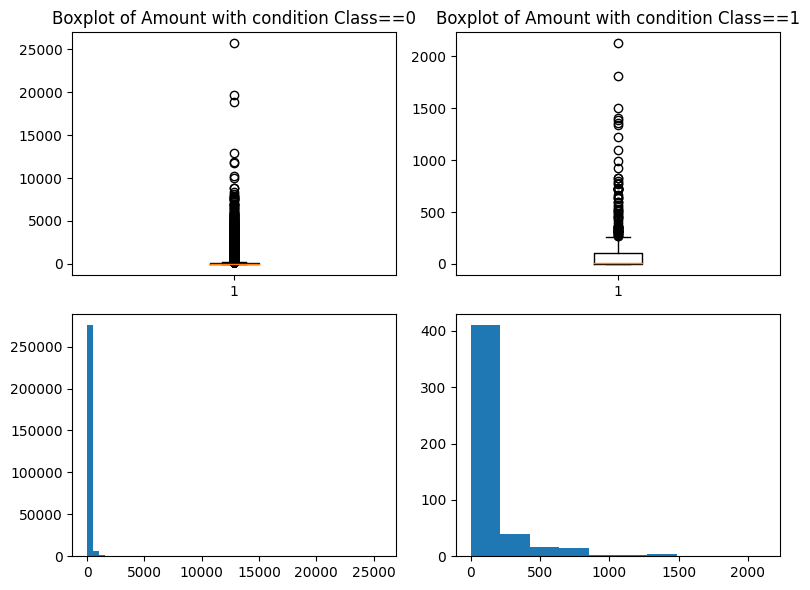

In [10]:
fig, ax = plt.subplots(2,2, figsize=(8,6))
ax[0,0].boxplot(df[df['Class']==0]['Amount'])
ax[0,0].set_title('Boxplot of Amount with condition Class==0')
ax[0,1].boxplot(df[df['Class']==1]['Amount'])
ax[0,1].set_title('Boxplot of Amount with condition Class==1')
ax[1,0].hist(df[df['Class']==0]['Amount'], bins=50)
ax[1,1].hist(df[df['Class']==1]['Amount'])
plt.tight_layout()

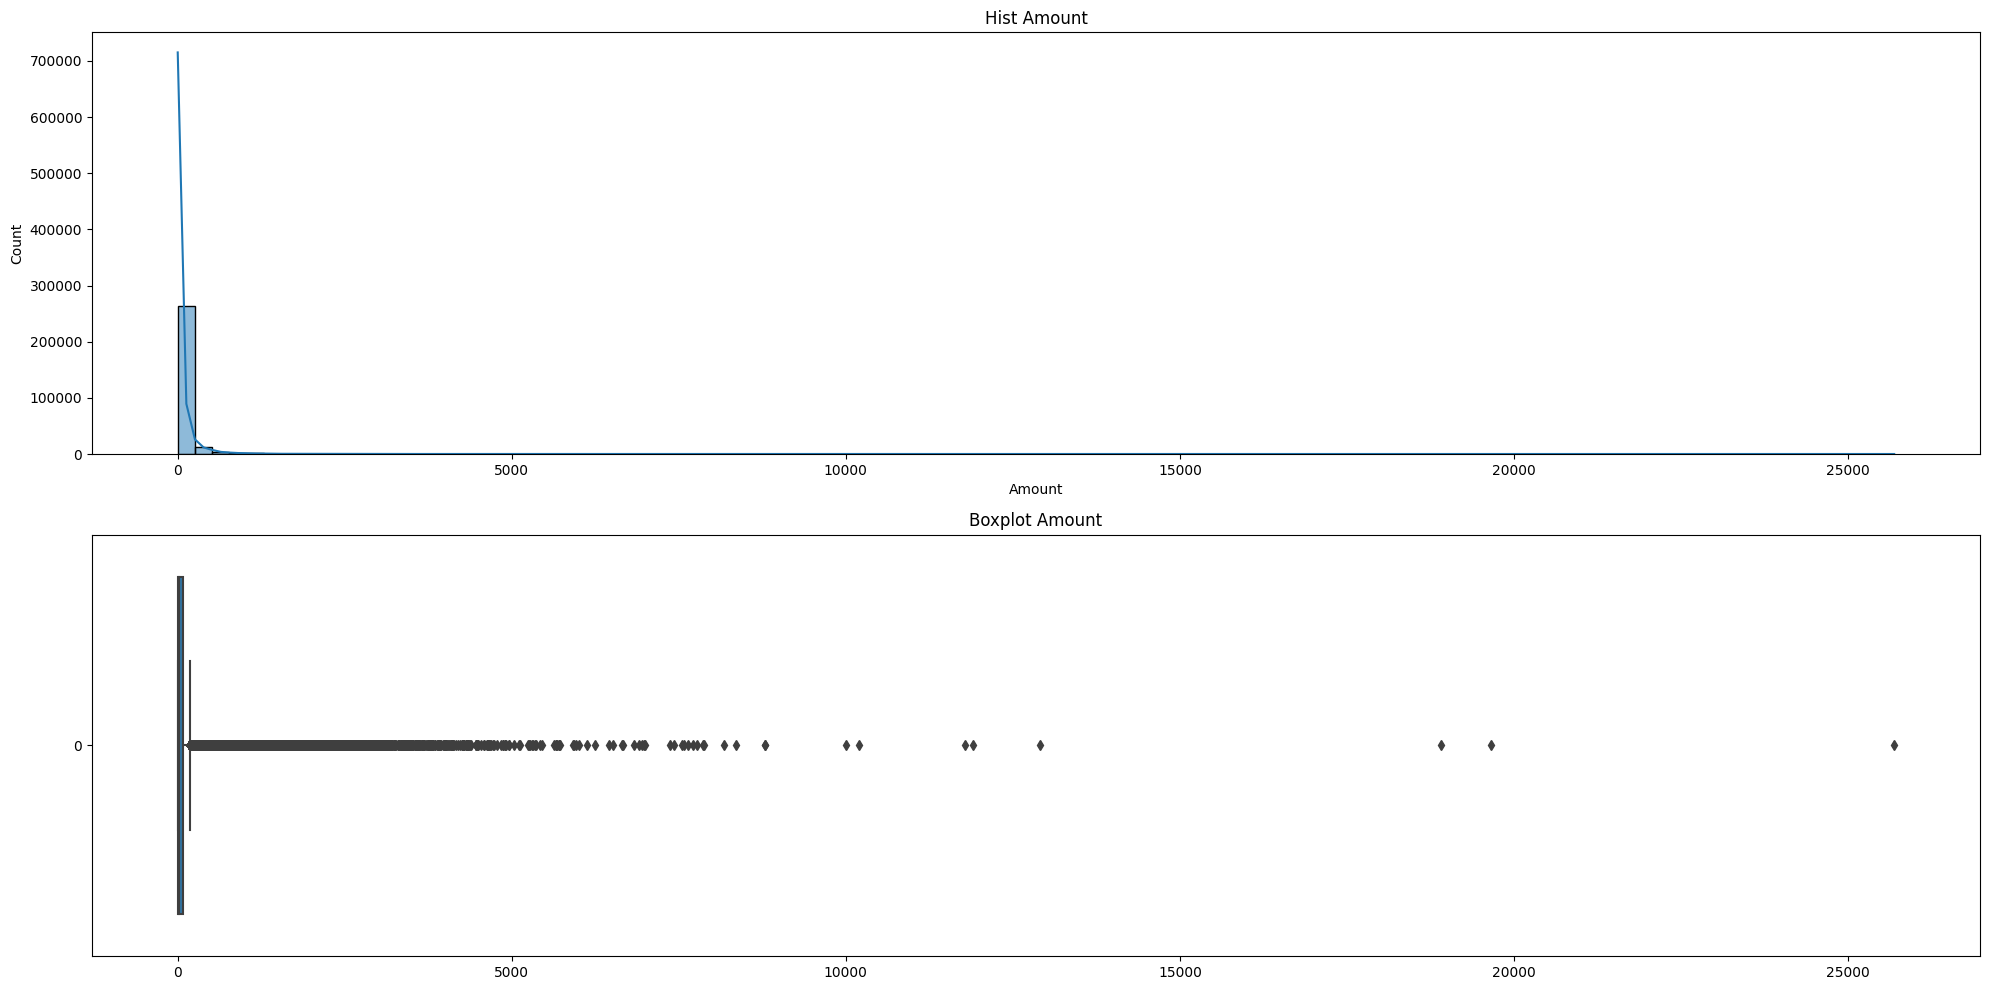

In [11]:
fig, axs = plt.subplots(2,1, figsize=(20,10))
sns.histplot(df['Amount'], bins=100, kde=True, ax=axs[0])
axs[0].set_title('Hist Amount')
sns.boxplot(df['Amount'], ax=axs[1], orient='h')
axs[1].set_title('Boxplot Amount')

plt.tight_layout()

{'whiskers': [<matplotlib.lines.Line2D at 0x7a7b7d2e5c00>,
 'caps': [<matplotlib.lines.Line2D at 0x7a7b7d2e69e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a7b7d2e6a70>],
 'medians': [<matplotlib.lines.Line2D at 0x7a7b7d2e6800>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a7b7d2e6ce0>],
 'means': []}

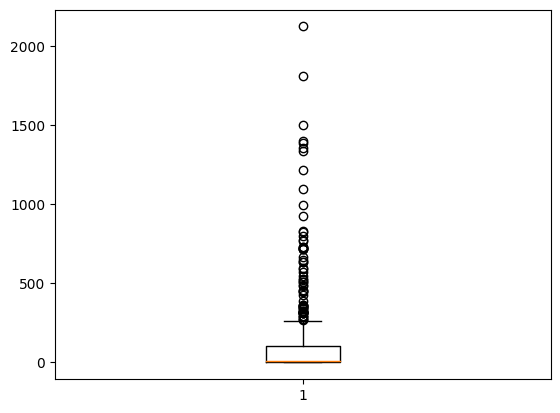

In [12]:
plt.boxplot(df[df['Class']==1]['Amount'])

<Axes: >

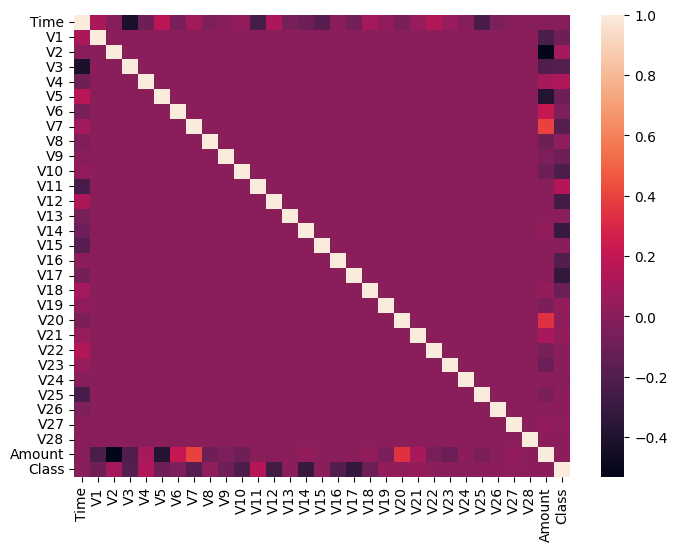

In [13]:
# Data Correlation -> since PCA is done, there should not be any correlation in V1....V28

corr = df.corr()

fig, ax = plt.subplots(1,1, figsize=(8,6))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

* no correleation between the features of V1-V28 as expected (after PCA)

# Data Preprocessing

* column Amount -> z-score normalization
* splitting data into feature & target data set
* splitting data into train & test set
* handle missing values -> impute mean values of column

In [14]:
# z-score normalization
scaler = StandardScaler()
df['Amount']=scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [15]:
# splitting data into feature & target data set
X = df.drop('Class', axis=1)
y = df['Class']

In [16]:
y.describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

In [17]:
# Splitting into train & test data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=42)
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [18]:
# impute mean values of column for missing values in feature data set --> no missing data

#imputer = SimpleImputer(strategy='mean')
#X_train_imputed = imputer.fit_transform(X_train)
#X_test_imputed = imputer.fit_transform(X_test)

In [19]:
# scale imputed features

#scaler=StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_imputed)
#X_test_scaled = scaler.fit_transform(X_test_imputed)

scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print(type(X_train_scaled))

<class 'numpy.ndarray'>


# Model

## Random Forest Classifier
* criterion (loss function): GINI = 2 * (AUC) - 1
* n_estimators -> number of trees
* max_depth -> depth of the trees. default: until all leaves are pure or leafes have samples < min_samples_split
* min_samples_split: minimum samples that are required to split the node (default: 2)
* min_samples_leaf -> minimum number of samples that are required in a leaf (default: 1)
* bootstrap: is bootstrap applied (default: 1)
* verbose: will give you information about the training

In [20]:
clf = RandomForestClassifier(n_estimators = 100,
                             random_state = 42,
                             criterion = 'gini',
                             verbose = 2
                            )

In [21]:
clf.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.8min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(random_state=42, verbose=2)

In [22]:
y_test.head()

43428     1
49906     0
29474     0
276481    0
278846    0
Name: Class, dtype: int64

In [23]:
pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


### Feature importance
visualization

In [24]:
featimp_df = pd.DataFrame({'Feature':X.columns, 'Feature Importance': clf.feature_importances_})
featimp_df = featimp_df.sort_values(by='Feature Importance', ascending=False)
featimp_df.head()

,Feature,Feature Importance
17,V17,0.157526
12,V12,0.134800
14,V14,0.124608
10,V10,0.081166
16,V16,0.074635


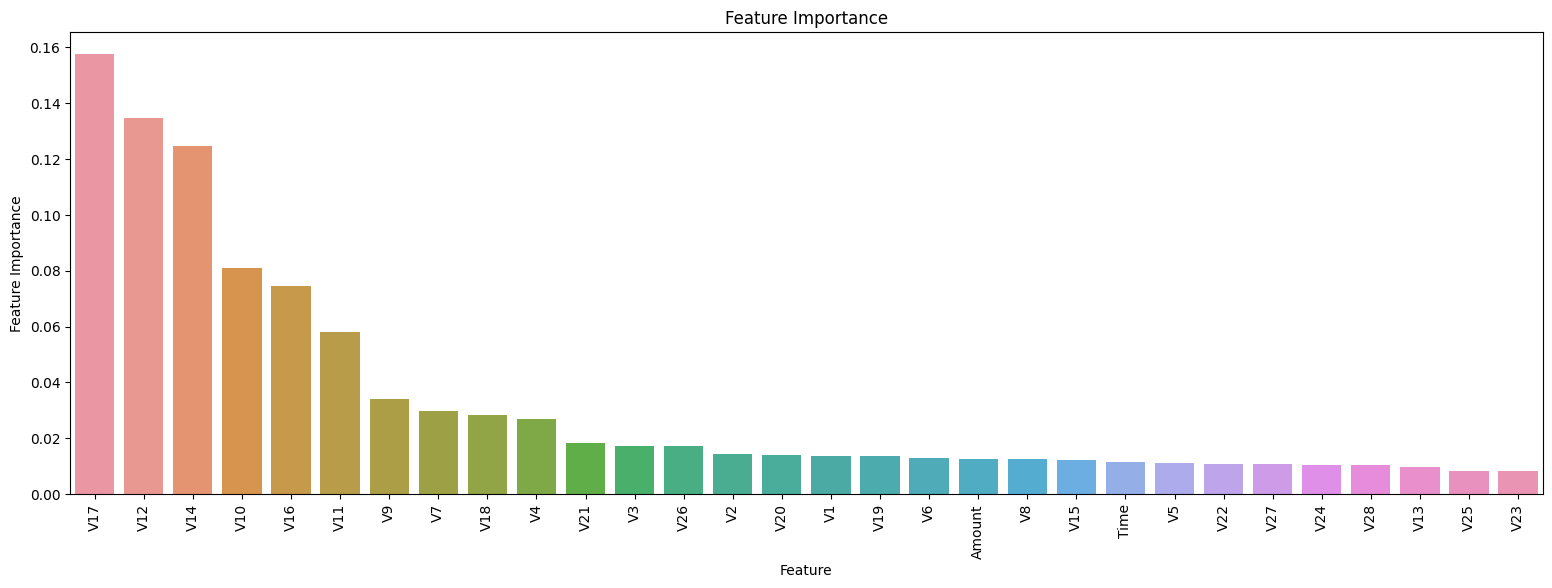

In [25]:
fig, ax = plt.subplots(1,1, figsize=(19,6))
ax.set_title('Feature Importance')
ax = sns.barplot(x='Feature', y='Feature Importance', data=featimp_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

most important features: V17, V12, V14, V10, V16, V11

### Confusion Matrix

In [26]:
pred

array([1, 0, 0, ..., 0, 0, 0])

Text(0.5, 1.0, 'Confusion Matrix')

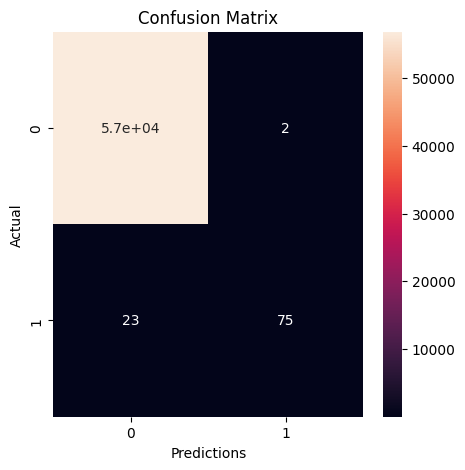

In [27]:
confusion_matrix = pd.crosstab(y_test.values, pred, rownames=['Actual'], colnames=['Predictions'])
#confusion_matrix

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = sns.heatmap(confusion_matrix, annot=True)
ax.set_title('Confusion Matrix')

confusion matrix is not a good tool to represent the result beacause the data are unbalanced -> use ROC-AUC score.

### ROC-AUC score

In [28]:
roc_auc_score(y_test.values, pred)

0.8826354754056941

# AdaBoostClassifier
Adaptive Boosting Classifier
* n_estimator: max number of estimators which boosting is terminated
* learning rate: weight applied to each classifier at each boosting iteration
* 'SAMME.R' real boosting algorithm
* random_state = random seed at each estimator at each boosting iteration

In [29]:
#prepare model
clf = AdaBoostClassifier(random_state=2018,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=100
                        )

In [30]:
#fit the model
clf.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [31]:
#predict target value for validation data
pred = clf.predict(X_test)

## Feature Importance

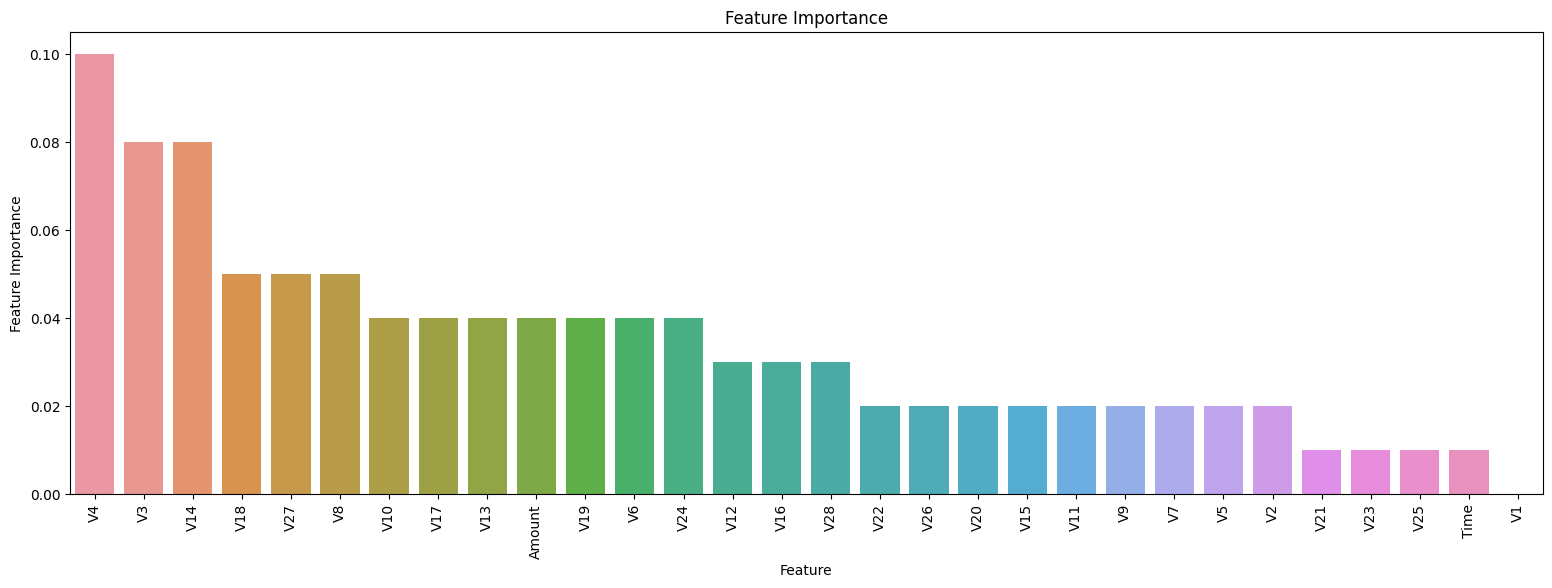

In [32]:
featimp_df = pd.DataFrame({'Feature':X.columns, 'Feature Importance': clf.feature_importances_})
featimp_df = featimp_df.sort_values(by='Feature Importance', ascending=False)
featimp_df.head()

fig, ax = plt.subplots(1,1, figsize=(19,6))
ax.set_title('Feature Importance')
ax = sns.barplot(x='Feature', y='Feature Importance', data=featimp_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## ROC-AUC Score

In [33]:
roc_auc_score(y_test.values, pred)

0.8672678025909294